In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name

conf = (SparkConf().setMaster("k8s://https://192.168.219.100:6443") # Your master address name
        .set("spark.kubernetes.container.image", "joron1827/pyspark:v2") # Spark image name
        .set("spark.driver.port", "2222") # Needs to match svc
        .set("spark.driver.blockManager.port", "7777")
        .set("spark.driver.host", "driver-service.jupyterhub.svc.cluster.local") # Needs to match svc
        .set("spark.driver.bindAddress", "0.0.0.0")
        .set("spark.kubernetes.namespace", "spark")
        .set("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")
        .set("spark.kubernetes.authenticate.serviceAccountName", "spark")
        .set("spark.executor.instances", "4")
        .set("spark.kubernetes.container.image.pullPolicy", "IfNotPresent")
        .set("spark.app.name", "joronSpark")
        .set("spark.executor.cores", "4")
        .set("spark.executor.memory", "12g"))

In [2]:

spark = SparkSession.builder.config(conf=conf).getOrCreate()

import time

time.sleep(10)

/home/jovyan/.local/lib/python3.9/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found


23/06/13 05:29:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [48]:
spark.stop()

23/06/13 06:02:29 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.


In [16]:
import pandas as pd

df = pd.read_csv('text_for_test.csv')
df2 = pd.read_csv('text_for_test2.csv')

df = pd.concat([df,df2], axis=0)
df


,code,date,title,views,pos,neg
0,010780,2023.06.03 08:53,이제는,558,0,3
1,010780,2023.06.02 12:45,주가부양의 전제시점,1487,4,3
2,010780,2023.06.02 12:23,매수는 또 손절은,1274,2,1
3,010780,2023.06.02 09:21,회사에 돈도 있는데 왜 돈빌리냐?,1047,1,2
4,010780,2023.06.01 23:46,"에휴, 한마디만 해라",1094,3,0
...,...,...,...,...,...,...
122396,126720,2023.06.05 13:39,주가가 바닥에서 기는 이유..,1772,6,3
122397,126720,2023.06.05 09:09,연배가 비슷한 라이온캠텍 대표 와 극과극,1601,4,0
122398,126720,2023.06.05 09:02,시초 거래량 죽이네 ㅎ,1634,2,1
122399,126720,2023.06.04 09:39,수산?더스트리는 여기대표를 보고배워라,2231,6,0


In [21]:
df= df.drop_duplicates(['date','title'])
df = df.dropna()

In [46]:
simple_text_df = spark.createDataFrame(df)
simple_text_df.show()

/home/jovyan/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/home/jovyan/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


23/06/13 05:42:15 WARN TaskSetManager: Stage 0 contains a task of very large size (1670 KiB). The maximum recommended task size is 1000 KiB.


+------+----------------+------------------------------------+-----+---+---+
|  code|            date|                               title|views|pos|neg|
+------+----------------+------------------------------------+-----+---+---+
|010780|2023.06.03 08:53|                              이제는|  558|  0|  3|
|010780|2023.06.02 12:45|                 주가부양의 전제시점| 1487|  4|  3|
|010780|2023.06.02 12:23|                   매수는 또 손절은 | 1274|  2|  1|
|010780|2023.06.02 09:21|     회사에 돈도 있는데 왜 돈빌리냐?| 1047|  1|  2|
|010780|2023.06.01 23:46|               에휴,  한마디만 해라 | 1094|  3|  0|
|010780|2023.06.01 23:26|                    공매도가 늘었네?|  509|  1|  0|
|010780|2023.06.01 17:38|                     에제 들어왔는데|  365|  0|  2|
|010780|2023.06.01 15:37|                ir을 어떻게한거야...|  791|  5|  0|
|010780|2023.06.01 13:41|          대형 배터리업체 계약준비중| 1137|  5|  5|
|010780|2023.06.01 12:19|                            온숙아 !|  867|  4|  0|
|010780|2023.06.01 13:58|                            온숙아 !|  208|  0|  1|
|

In [47]:
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# 정규식 패턴을 이용한 데이터 전처리 함수 정의
def preprocess_text(text):
    cleaned_text = re.sub(r'[^ ㄱ-ㅎ가-힣 ]+', '', text)
    return cleaned_text

# UDF(사용자 정의 함수) 등록
preprocess_udf = udf(preprocess_text, StringType())

# 전처리 함수를 적용하여 새로운 컬럼 생성
preprocessed_df = simple_text_df.withColumn("title", preprocess_udf("title"))

# 결과 확인
preprocessed_df.show()

23/06/13 05:42:23 WARN TaskSetManager: Stage 1 contains a task of very large size (1670 KiB). The maximum recommended task size is 1000 KiB.


+------+----------------+------------------------------------+-----+---+---+
|  code|            date|                               title|views|pos|neg|
+------+----------------+------------------------------------+-----+---+---+
|010780|2023.06.03 08:53|                              이제는|  558|  0|  3|
|010780|2023.06.02 12:45|                 주가부양의 전제시점| 1487|  4|  3|
|010780|2023.06.02 12:23|                   매수는 또 손절은 | 1274|  2|  1|
|010780|2023.06.02 09:21|      회사에 돈도 있는데 왜 돈빌리냐| 1047|  1|  2|
|010780|2023.06.01 23:46|                에휴  한마디만 해라 | 1094|  3|  0|
|010780|2023.06.01 23:26|                     공매도가 늘었네|  509|  1|  0|
|010780|2023.06.01 17:38|                     에제 들어왔는데|  365|  0|  2|
|010780|2023.06.01 15:37|                     을 어떻게한거야|  791|  5|  0|
|010780|2023.06.01 13:41|          대형 배터리업체 계약준비중| 1137|  5|  5|
|010780|2023.06.01 12:19|                             온숙아 |  867|  4|  0|
|010780|2023.06.01 13:58|                             온숙아 |  208|  0|  1|
|

In [6]:
file_path = 'stopwords.txt'  # 파일 경로 설정

with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    stopword_list = [line.strip() for line in lines]
    
print(stopword_list)

['가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공동으로', '과', '과연', '관계가 있다', '관계없이', '관련이 있다', '관하여', '관한', '관해서는', '구', '구체적으로', '구토하다', '그', '그들', '그때', '그래', '그래도', '그래서', '그러나', '그러니', '그러니까', '그러면', '그러므로', '그러한즉', '그런 까닭에', '그런데', '그런즉', '그럼', '그럼에도 불구하고', '그렇게 함으로써', '그렇지', '그렇지 않다면', '그렇지 않으면', '그렇지만', '그렇지않으면', '그리고', '그리하여', '그만이다', '그에 따르는', '그위에', '그저', '그중에서', '그치지 않다', '근거로', '근거하여', '기대여', '기점으로', '기준으로', '기타', '까닭으로', '까악', '까지', '까지 미치다', '까지도', '꽈당', '끙끙', '끼익', '나', '나머지는', '남들', '남짓', '너', '너희', '너희들', '네', '넷', '년', '논하지 않다', '놀라다', '누가 알겠는가', '누구', '다른', '다른 방면으로', '다만', '다섯', '다소', '다수', '다시 말하자면', '다시말하면', '다음', '다음에', '다음으로', '단지', '답다', '당신', '당장', '대로 하다', '대하면', '대하여', '대해 말하자면', '대해서', '댕그', '더구나', '더군다나', '더라도', '더불어', '더욱더', '더욱이는', '도달하다', '도착하다', '동시에', '동안', '된바에야', '된이상', '두번째로', '둘', '둥둥', '뒤따라', '뒤이어'

In [7]:
from pyspark.sql.functions import *
from pyspark.sql.types import Row
from konlpy.tag import Okt


def extract_nouns(content):
    okt = Okt()
    tokens = okt.morphs(content)
    tokens = [token for token in tokens if token not in stopword_list]
    
    return tokens

extract_nouns_udf = udf(extract_nouns, ArrayType(StringType()))

tokenized_df = preprocessed_df.withColumn("tokens", extract_nouns_udf("title"))

tokenized_df.show()


23/06/04 19:47:07 WARN TaskSetManager: Stage 2 contains a task of very large size (1209 KiB). The maximum recommended task size is 1000 KiB.


+------+----------------+------------------------------------+-----+---+---+------------------------------+
|  code|            date|                               title|views|pos|neg|                        tokens|
+------+----------------+------------------------------------+-----+---+---+------------------------------+
|010780|2023.06.03 08:53|                              이제는|  558|  0|  3|                    [이제, 는]|
|010780|2023.06.02 12:45|                 주가부양의 전제시점| 1487|  4|  3|    [주, 가부, 양, 전제, 시점]|
|010780|2023.06.02 12:23|                   매수는 또 손절은 | 1274|  2|  1|          [매수, 는, 손절, 은]|
|010780|2023.06.02 09:21|      회사에 돈도 있는데 왜 돈빌리냐| 1047|  1|  2|  [회사, 돈, 도, 있는데, 돈...|
|010780|2023.06.01 23:46|                에휴  한마디만 해라 | 1094|  3|  0|                  [만, 해, 라]|
|010780|2023.06.01 23:26|                     공매도가 늘었네|  509|  1|  0|              [공매도, 늘었네]|
|010780|2023.06.01 17:38|                     에제 들어왔는데|  365|  0|  2|                  [들어왔는데]|
|010780|2023.

In [9]:
save_path = "hdfs://192.168.219.121:9000/crawling_stock_text_merge/text_tokens_label_test.parquet"

tokenized_df.write.parquet(save_path)
### 임시 저장

23/06/04 06:49:35 WARN TaskSetManager: Stage 3 contains a task of very large size (1209 KiB). The maximum recommended task size is 1000 KiB.


In [8]:
## 다시 불러오기
save_path = "hdfs://192.168.219.121:9000/crawling_stock_text_merge/text_tokens_label_test.parquet"

tokenized_df = spark.read.parquet(save_path)
tokenized_df.show()

+------+----------------+----------------------------------+-----+---+---+------------------------------+
|  code|            date|                             title|views|pos|neg|                        tokens|
+------+----------------+----------------------------------+-----+---+---+------------------------------+
|030210|2023.05.09 14:54|     라덕연 체포로 불똥이 여기에도|  539|  4|  7|  [라, 덕연, 체포, 불똥, 에도]|
|030210|2023.05.09 14:54|                         오마이 갓|  390|  3|  1|                  [오마이, 갓]|
|030210|2023.05.09 14:53|                       금일 백만주|  536|  5|  0|              [금일, 백, 만주]|
|030210|2023.05.09 14:52|                           난 일단|  107|  0|  0|                          [난]|
|030210|2023.05.09 14:43|                               난 |  336|  1|  0|                          [난]|
|030210|2023.05.09 14:43| 개미 털면서 야금야금 가는게 냄...|  387|  3|  0|[개미, 털면서, 야금야금, 가...|
|030210|2023.05.09 14:42|                          가지고가|  327|  1|  0|                  [가지, 고가]|
|030210|2023.05.0

In [14]:
from pyspark.sql.functions import explode, col, array_except, array, lit, udf
from pyspark.sql.types import ArrayType, StringType

top_words_list = ['은', '오늘', '는', '다', '도', '만', '주', '원', '한', '개미', '매수', '된', '삭제', '게시', '물의', 'ㅋㅋ', '주식', '고', '답글', '안', '라', '개', '내일', '상', '시', '내', '매도', '만원', '대', '이다']

filter_words = udf(lambda tokens: [word for word in tokens if word not in top_words_list], ArrayType(StringType()))

# Add a new column 'filtered_tokens' with only the words present in top_words_list
filtered_df = tokenized_df.withColumn('filtered_tokens', filter_words(col('tokens')))

filtered_df.show()

+------+----------------+----------------------------------+-----+---+---+------------------------------+------------------------------+
|  code|            date|                             title|views|pos|neg|                        tokens|               filtered_tokens|
+------+----------------+----------------------------------+-----+---+---+------------------------------+------------------------------+
|030210|2023.05.09 14:54|     라덕연 체포로 불똥이 여기에도|  539|  4|  7|  [라, 덕연, 체포, 불똥, 에도]|      [덕연, 체포, 불똥, 에도]|
|030210|2023.05.09 14:54|                         오마이 갓|  390|  3|  1|                  [오마이, 갓]|                  [오마이, 갓]|
|030210|2023.05.09 14:53|                       금일 백만주|  536|  5|  0|              [금일, 백, 만주]|              [금일, 백, 만주]|
|030210|2023.05.09 14:52|                           난 일단|  107|  0|  0|                          [난]|                          [난]|
|030210|2023.05.09 14:43|                               난 |  336|  1|  0|                          [난]|

In [15]:
filtered_df = filtered_df.dropDuplicates(["title","tokens"])
filtered_df.show()
filtered_df.count()

+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+
|  code|            date|                          title|views|pos|neg|                        tokens|              filtered_tokens|
+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+
|031820|2023.05.30 23:12|                             ㅎ|  138|  0|  0|                          [ㅎ]|                         [ㅎ]|
|298690|2023.05.04 14:40|                 어디 박혀 있냐|  548|  2|  1|                  [박혀, 있냐]|                 [박혀, 있냐]|
|259960|2023.06.02 08:11|                    동일 다계정|  554|  6|  2|              [동일, 다, 계정]|                 [동일, 계정]|
|011070|2023.05.11 12:26|                   주ㅋㅋㅋㅋㅋ|  329|  3|  4|              [주, ㅋㅋㅋㅋㅋ]|                 [ㅋㅋㅋㅋㅋ]|
|004360|2023.05.30 12:11|                 참 생쇼를 하네|  256|  2|  1|                  [생쇼, 하네]|                 [생쇼, 하네]

253992

In [16]:
from pyspark.sql.types import BooleanType


# UDF 정의
def is_empty_string(value):
    return len(value) == 0

# UDF 등록
is_empty_string_udf = udf(is_empty_string, BooleanType())

# filtered_tokens 컬럼의 빈 문자열을 결측치로 간주하여 제거
df_filtered = filtered_df.filter(~is_empty_string_udf(col("filtered_tokens")))

# 결과 출력
df_filtered.show()
df_filtered.count()
df_filtered.printSchema()


+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+
|  code|            date|                          title|views|pos|neg|                        tokens|              filtered_tokens|
+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+
|031820|2023.05.30 23:12|                             ㅎ|  138|  0|  0|                          [ㅎ]|                         [ㅎ]|
|298690|2023.05.04 14:40|                 어디 박혀 있냐|  548|  2|  1|                  [박혀, 있냐]|                 [박혀, 있냐]|
|259960|2023.06.02 08:11|                    동일 다계정|  554|  6|  2|              [동일, 다, 계정]|                 [동일, 계정]|
|011070|2023.05.11 12:26|                   주ㅋㅋㅋㅋㅋ|  329|  3|  4|              [주, ㅋㅋㅋㅋㅋ]|                 [ㅋㅋㅋㅋㅋ]|
|004360|2023.05.30 12:11|                 참 생쇼를 하네|  256|  2|  1|                  [생쇼, 하네]|                 [생쇼, 하네]

root
 |-- code: string (nullable = true)
 |-- date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- views: long (nullable = true)
 |-- pos: long (nullable = true)
 |-- neg: long (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [17]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import PipelineModel


# 모델 로드
loaded_model = PipelineModel.load("hdfs://192.168.219.121:9000/crawling_stock_text_merge/hashing_idf_model")


# 데이터 변환
transformed_data = loaded_model.transform(df_filtered)

# 결과 출력
transformed_data.show()

23/06/04 07:04:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+
|  code|            date|                          title|views|pos|neg|                        tokens|              filtered_tokens|                  tf|               tfidf|
+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+
|031820|2023.05.30 23:12|                             ㅎ|  138|  0|  0|                          [ㅎ]|                         [ㅎ]|(262144,[233464],...|(262144,[233464],...|
|298690|2023.05.04 14:40|                 어디 박혀 있냐|  548|  2|  1|                  [박혀, 있냐]|                 [박혀, 있냐]|(262144,[31205,13...|(262144,[31205,13...|
|259960|2023.06.02 08:11|                    동일 다계정|  554|  6|  2|              [동일, 다, 계정]|                 [동일, 계정]|(262144,[104240,1...|(26

In [18]:
from pyspark.ml.classification import LogisticRegressionModel

# 모델 로드
loaded_lr_model = LogisticRegressionModel.load("hdfs://192.168.219.121:9000/crawling_stock_text_merge/lr_model")

# 데이터 변환
new_data = loaded_lr_model.transform(transformed_data)

# 결과 출력
new_data.show()

23/06/04 07:04:20 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  code|            date|                          title|views|pos|neg|                        tokens|              filtered_tokens|                  tf|               tfidf|       rawPrediction|         probability|prediction|
+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|031820|2023.05.30 23:12|                             ㅎ|  138|  0|  0|                          [ㅎ]|                         [ㅎ]|(262144,[233464],...|(262144,[233464],...|[-0.7480319607002...|[0.32125027786757...|       1.0|
|298690|2023.05.04 14:40|                 어디 박혀 있냐|  548|  2|  1|                  [박혀, 있냐]

In [23]:
new_data.printSchema()

root
 |-- code: string (nullable = true)
 |-- date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- views: long (nullable = true)
 |-- pos: long (nullable = true)
 |-- neg: long (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [26]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType




from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# UDF(사용자 정의 함수)를 생성하여 두 값을 계산하는 함수 정의
def calculate_difference(vector):
    return vector[0] - vector[1]

# UDF 등록
calculate_difference_udf = udf(calculate_difference, DoubleType())

# 새로운 열 추가
df_with_difference = new_data.withColumn('difference', calculate_difference_udf('probability'))

# 결과 출력
df_with_difference.show()

23/06/04 07:10:55 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 07:10:56 WARN TaskSetManager: Lost task 0.0 in stage 40.0 (TID 166) (10.244.1.90 executor 6): net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for numpy.dtype). This happens when an unsupported/unregistered class is being unpickled that requires construction arguments. Fix it by registering a custom IObjectConstructor for this class.
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:759)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:199)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$6(BatchEvalPythonExec.scala:94)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collectio

Py4JJavaError: An error occurred while calling o434.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 40.0 failed 4 times, most recent failure: Lost task 0.3 in stage 40.0 (TID 169) (10.244.1.90 executor 6): net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for numpy.dtype). This happens when an unsupported/unregistered class is being unpickled that requires construction arguments. Fix it by registering a custom IObjectConstructor for this class.
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:759)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:199)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$6(BatchEvalPythonExec.scala:94)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:506)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:459)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:373)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3868)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3084)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:288)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:327)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for numpy.dtype). This happens when an unsupported/unregistered class is being unpickled that requires construction arguments. Fix it by registering a custom IObjectConstructor for this class.
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:759)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:199)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$6(BatchEvalPythonExec.scala:94)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)


In [31]:
from pyspark.sql.functions import col

df_with_difference = new_data.withColumn('difference', col('probability')[0] - col('probability')[1])


AnalysisException: Can't extract value from probability#647: need struct type but got struct<type:tinyint,size:int,indices:array<int>,values:array<double>>

In [34]:
from pyspark.sql.functions import col

first_row = new_data.select(col('probability')).first()
probability_values = first_row['probability'].values

print(probability_values)
print(type(probability_values))

23/06/04 07:16:01 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
[0.32125028 0.67874972]
<class 'numpy.ndarray'>


In [46]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

# UDF 정의
extract_values_udf = udf(lambda probability: probability.values.tolist(), ArrayType(DoubleType()))

# values 추출하여 새로운 열 추가
df_with_values = new_data.withColumn('values', extract_values_udf(col('probability')))

# 결과 확인
df_with_values.show()

23/06/04 07:22:57 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|  code|            date|                          title|views|pos|neg|                        tokens|              filtered_tokens|                  tf|               tfidf|       rawPrediction|         probability|prediction|              values|
+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|031820|2023.05.30 23:12|                             ㅎ|  138|  0|  0|                          [ㅎ]|                         [ㅎ]|(262144,[233464],...|(262144,[233464],...|[-0.7480319607002...|[0.32125027786757...|       1.0|[0.32125027786757...|
|298690

In [49]:
from pyspark.sql.functions import col

# values 열의 데이터 차 구하기
df_with_diff = df_with_values.withColumn('diff', col('values')[0] - col('values')[1])

# values 열에 재할당
df_with_diff = df_with_diff.withColumn('values', col('diff'))

# 결과 확인
df_with_diff.show()

23/06/04 07:26:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+
|  code|            date|                          title|views|pos|neg|                        tokens|              filtered_tokens|                  tf|               tfidf|       rawPrediction|         probability|prediction|              values|                diff|
+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+
|031820|2023.05.30 23:12|                             ㅎ|  138|  0|  0|                          [ㅎ]|    

In [51]:
from pyspark.sql.functions import abs

# values 열의 값에 절대값 적용
df_with_abs_values = df_with_diff.withColumn('values', abs(col('values')))

# 결과 확인
df_with_abs_values.show()

23/06/04 07:27:20 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+
|  code|            date|                          title|views|pos|neg|                        tokens|              filtered_tokens|                  tf|               tfidf|       rawPrediction|         probability|prediction|              values|                diff|
+------+----------------+-------------------------------+-----+---+---+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+
|031820|2023.05.30 23:12|                             ㅎ|  138|  0|  0|                          [ㅎ]|    

In [106]:
selected_df = df_with_abs_values.select('code', 'date', 'title','filtered_tokens', 'prediction', 'values')

selected_df.show()

23/06/04 10:44:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
+------+----------------+-------------------------------+-----------------------------+----------+--------------------+
|  code|            date|                          title|              filtered_tokens|prediction|              values|
+------+----------------+-------------------------------+-----------------------------+----------+--------------------+
|031820|2023.05.30 23:12|                             ㅎ|                         [ㅎ]|       1.0| 0.35749944426484426|
|298690|2023.05.04 14:40|                 어디 박혀 있냐|                 [박혀, 있냐]|       0.0|0.019712632001659625|
|259960|2023.06.02 08:11|                    동일 다계정|                 [동일, 계정]|       0.0| 0.38328624778103526|
|011070|2023.05.11 12:26|                   주ㅋㅋㅋㅋㅋ|                 [ㅋㅋㅋㅋㅋ]|       1.0|  0.3978921901076849|
|004360|2023.05.30 12:11|                 참 생쇼를 하네|                 [생쇼, 하네]|       1.0|  0.13040570094836

In [107]:
from pyspark.sql.functions import when

updated_df = selected_df.withColumn('prediction', when((selected_df['values'] <= 0.3) | (selected_df['values'] >= 0.7), selected_df['prediction']).otherwise(2))

updated_df.show()

23/06/04 10:44:49 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
+------+----------------+-------------------------------+-----------------------------+----------+--------------------+
|  code|            date|                          title|              filtered_tokens|prediction|              values|
+------+----------------+-------------------------------+-----------------------------+----------+--------------------+
|031820|2023.05.30 23:12|                             ㅎ|                         [ㅎ]|       2.0| 0.35749944426484426|
|298690|2023.05.04 14:40|                 어디 박혀 있냐|                 [박혀, 있냐]|       0.0|0.019712632001659625|
|259960|2023.06.02 08:11|                    동일 다계정|                 [동일, 계정]|       2.0| 0.38328624778103526|
|011070|2023.05.11 12:26|                   주ㅋㅋㅋㅋㅋ|                 [ㅋㅋㅋㅋㅋ]|       2.0|  0.3978921901076849|
|004360|2023.05.30 12:11|                 참 생쇼를 하네|                 [생쇼, 하네]|       1.0|  0.13040570094836

In [108]:
from pyspark.sql.functions import explode, col

# Explode the 'filtered_tokens' array column to get each word as a separate row
exploded_df = updated_df.select('prediction', explode(col('filtered_tokens')).alias('word'))

# Group by 'prediction' and 'word', and count the occurrences of each word
word_count_df = exploded_df.groupBy('prediction', 'word').count()

# Show the resulting DataFrame
word_count_df.show()

23/06/04 10:46:26 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 10:46:28 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
+----------+--------+-----+
|prediction|    word|count|
+----------+--------+-----+
|       1.0|    수온|    2|
|       2.0|  간략한|    2|
|       1.0|  금요일|   85|
|       1.0|  얹히냐|    1|
|       1.0|    동원|   24|
|       1.0|      현|  306|
|       1.0|    맞나|   21|
|       1.0|      까|  135|
|       2.0|  현대차|  225|
|       1.0|    귀신|   14|
|       1.0|    초기|   11|
|       1.0|늘어나죠|    1|
|       2.0|  정신과|    1|
|       1.0|    질문|   50|
|       0.0|    강한|    7|
|       2.0|  도라지|    1|
|       1.0|  떨군거|    2|
|       1.0|    되는|  104|
|       0.0|    경아|    1|
|       1.0|    대로|  153|
+----------+--------+-----+
only showing top 20 rows



In [110]:
from pyspark.sql.functions import desc, dense_rank
from pyspark.sql.window import Window

# Calculate word counts for each prediction
word_count_df = exploded_df.groupBy('prediction', 'word').count()

# Rank the words based on their counts within each prediction
window_spec = Window.partitionBy('prediction').orderBy(desc('count'))
ranked_words_df = word_count_df.withColumn('rank', dense_rank().over(window_spec))

# Filter for the top 10 words for each prediction
top_10_words_df = ranked_words_df.filter(col('rank') <= 10)

# Show the resulting DataFrame
top_10_words_df.show()


23/06/04 10:47:56 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 10:47:58 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 10:47:59 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
+----------+------+-----+----+
|prediction|  word|count|rank|
+----------+------+-----+----+
|       0.0|  회사| 1067|   1|
|       0.0|  주가|  935|   2|
|       0.0|공매도|  623|   3|
|       0.0|  상승|  524|   4|
|       0.0|  주주|  501|   5|
|       0.0|    못|  495|   6|
|       0.0|    중|  487|   7|
|       0.0|    지|  483|   8|
|       0.0|  실적|  462|   9|
|       0.0|  하는|  455|  10|
|       1.0|  주가| 1573|   1|
|       1.0|    지| 1345|   2|
|       1.0|    못| 1311|   3|
|       1.0|  실적| 1284|   4|
|       1.0|  종목| 1235|   5|
|       1.0|공매도| 1213|   6|
|       1.0|  상승| 1185|   7|
|       1.0|    거| 1182|   8|
|       1.0|    중| 1174|   9|
|       1.0|ㅋㅋㅋ| 1167|  10|
+----------+------+-----+----+
only showing top 20 rows



In [137]:
import pandas as pd

# Spark DataFrame에서 prediction이 0인 행만 필터링
prediction_0_df = top_10_words_df.filter(top_10_words_df['prediction'] == 2.0)

# Spark DataFrame을 pandas DataFrame으로 변환
prediction_0_pd = prediction_0_df.toPandas()

# pandas DataFrame으로부터 표 출력
prediction_0_pd


23/06/04 11:12:08 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 11:12:10 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 11:12:10 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


,prediction,word,count,rank
0,2.0,거,1770,1
1,2.0,ㅋㅋㅋ,1651,2
2,2.0,지,1578,3
3,2.0,못,1503,4
4,2.0,중,1502,5
5,2.0,거래,1480,6
6,2.0,간다,1438,7
7,2.0,요,1430,8
8,2.0,ㅋ,1393,9
9,2.0,더,1372,10


In [130]:
import matplotlib

matplotlib.get_cachedir()

'/home/jovyan/.cache/matplotlib'

/home/jovyan/spark processing


23/06/04 07:30:14 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 07:30:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 07:30:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 07:30:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 07:30:18 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 07:30:20 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 07:30:20 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 07:30:21 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


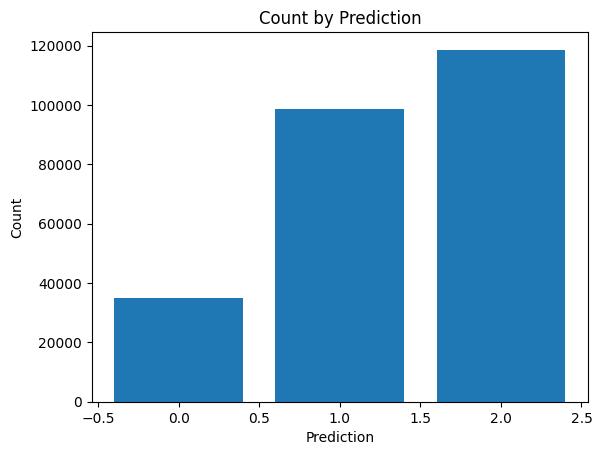

In [54]:
import matplotlib.pyplot as plt

# Prediction 값에 따른 Count 계산
prediction_count = updated_df.groupBy('prediction').count().orderBy('prediction')

# Count 데이터를 리스트로 변환
prediction_values = prediction_count.select('prediction').rdd.flatMap(lambda x: x).collect()
count_values = prediction_count.select('count').rdd.flatMap(lambda x: x).collect()

# 막대 그래프로 시각화
plt.bar(prediction_values, count_values)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Count by Prediction')
plt.show()

In [56]:
from pyspark.sql.functions import col, to_date, regexp_replace, substring

# 텍스트 데이터의 "date" 컬럼에서 "-"를 제거하여 형식을 변환합니다.
updated_df = updated_df.withColumn("date", substring(col("date"), 1, 10))
updated_df = updated_df.withColumn("date", to_date(regexp_replace(col("date"), "\\.", ""), "yyyyMMdd"))

updated_df.show()

23/06/04 07:55:39 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
+------+----------+-------------------------------+----------+--------------------+
|  code|      date|                          title|prediction|              values|
+------+----------+-------------------------------+----------+--------------------+
|031820|2023-05-30|                             ㅎ|       2.0| 0.35749944426484426|
|298690|2023-05-04|                 어디 박혀 있냐|       0.0|0.019712632001659625|
|259960|2023-06-02|                    동일 다계정|       2.0| 0.38328624778103526|
|011070|2023-05-11|                   주ㅋㅋㅋㅋㅋ|       2.0|  0.3978921901076849|
|004360|2023-05-30|                 참 생쇼를 하네|       1.0|  0.1304057009483634|
|002900|2023-05-26|                     출시      |       1.0| 0.25455546888799857|
|016380|2023-05-09|                    행운의 주문|       2.0|  0.6562478107557796|
|028050|2023-05-25|                    시작 죽이너|       1.0|  0.2441722148380545|
|001360|2023-05-26|       

In [80]:
import matplotlib.pyplot as plt

# code가 "000020"인 행들을 필터링
# filtered_df = updated_df.filter(updated_df.code == "352820")

# 일별로 그룹화하여 prediction별 count 계산
# grouped_df = filtered_df.groupBy("date", "prediction").count()
grouped_df = updated_df.groupBy("code","date").pivot("prediction").count().fillna(0)
grouped_df.show()

# # 히스토그램을 위한 데이터 준비
# dates = grouped_df.select("date").rdd.flatMap(lambda x: x).collect()
# predictions = grouped_df.select("prediction").rdd.flatMap(lambda x: x).collect()
# counts = grouped_df.select("count").rdd.flatMap(lambda x: x).collect()

# # 히스토그램 그리기
# plt.figure(figsize=(10, 6))
# plt.hist2d(dates, predictions, weights=counts, bins=[31, 3], cmap='Blues')
# plt.xlabel("Date")
# plt.ylabel("Prediction")
# plt.title("Count of Predictions for Code '000020'")
# plt.colorbar(label="Count")
# plt.xticks(rotation=45)
# plt.show()


23/06/04 08:46:07 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:46:08 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:46:08 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:46:08 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:46:10 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:46:11 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:46:12 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
+------+----------+---+---+---+
|  code|      date|0.0|1.0|2.0|
+------+----------+---+---+---+
|039130|2023-05-21|  0|  1|  0|
|015890|2023-05-12|  5| 26| 33|
|079550|2023-05-23|  1|  8|  4|
|006260|2023-05-19|  8| 26| 22|
|008930|2023-05-25|  0|  4|  6|
|003535|2023-05-28|  0|  0|  1|
|009150|2023-05-16|  8| 10| 12|
|001390|2023-05-20|  1|  2|  0|
|010140|2023-05-22| 18| 40| 79|
|010780|2023-05-09|  0|  3|  0|
|025820|2023-05-12|  0|  5|  9|
|033530|2023-05-09|  5| 24| 39|
|020150|2023-05-18| 36|109|103|
|011070|2023-05-08|  2| 34| 33|
|028050|2023-05-26|  5| 15| 17|
|010820|2023-05-18| 27|150|207|
|001790|2023-06-03|  2|  6|  7|
|383800|2023-05-12|  2|  4|  3|
|047400|2023-05-27|  6| 10| 20|
|298040|2023-05-11|  0|  1|  2|
+------+----------+---+---+---+
only showing top 20 rows



In [94]:
# Replace null values with 0
grouped_df_filled = grouped_df.fillna(0)

# Aggregate the counts by date
df = grouped_df_filled.groupBy("date").sum()

Py4JJavaError: An error occurred while calling o1447.sum.
: java.util.NoSuchElementException: None.get
	at scala.None$.get(Option.scala:529)
	at scala.None$.get(Option.scala:527)
	at org.apache.spark.sql.Dataset.$anonfun$numericColumns$2(Dataset.scala:264)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.mutable.ArrayOps$ofRef.map(ArrayOps.scala:198)
	at org.apache.spark.sql.Dataset.numericColumns(Dataset.scala:263)
	at org.apache.spark.sql.RelationalGroupedDataset.aggregateNumericColumns(RelationalGroupedDataset.scala:98)
	at org.apache.spark.sql.RelationalGroupedDataset.sum(RelationalGroupedDataset.scala:328)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [84]:
db_df = grouped_df.toPandas()

23/06/04 08:52:01 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:52:03 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:52:03 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:52:04 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:52:04 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


In [2]:
from sqlalchemy import create_engine
import pandas as pd


user = 'root'
passwd = 'root'
host = '192.168.219.123'
db = 'stock'

engine = create_engine(f'postgresql://{user}:{passwd}@{host}/{db}')
engine.connect()

query = f'SELECT * FROM predict_count;'

df=pd.read_sql(query, con=engine)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Group the DataFrame by date and sum the prediction columns
df = df.groupby('date').sum()

# Get the unique dates and sort them in ascending order
unique_dates = df.index.to_list()
unique_dates.sort()

# Get the counts for each prediction category in ascending order
count_0 = df['0.0'].loc[unique_dates].values
count_1 = df['1.0'].loc[unique_dates].values
count_2 = df['2.0'].loc[unique_dates].values

/tmp/ipykernel_10506/3767461637.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('date').sum()


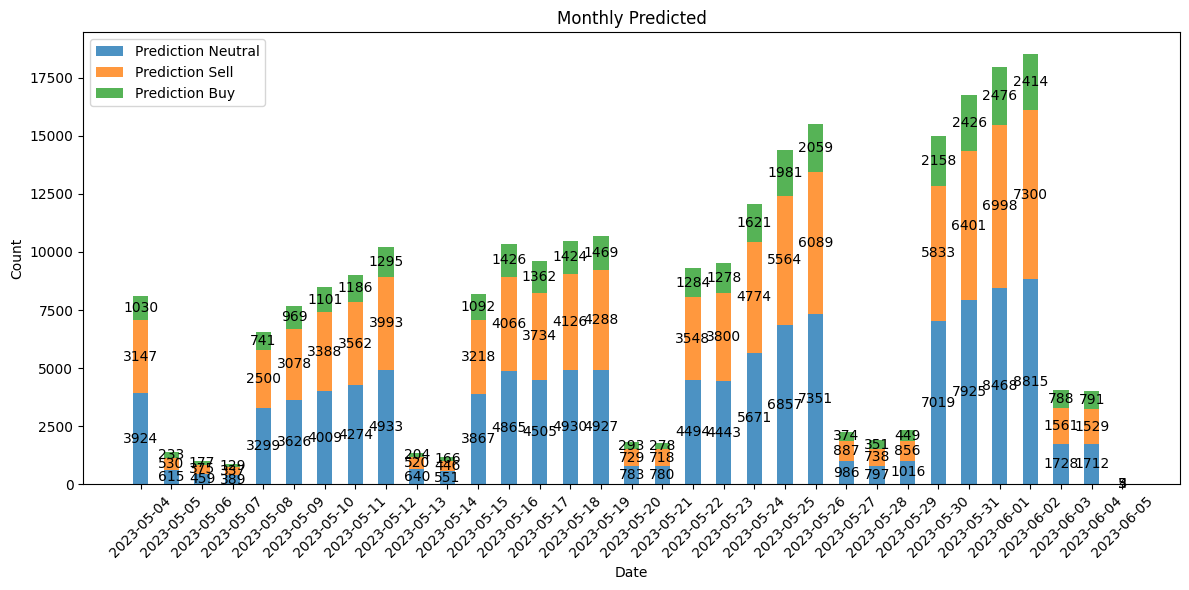

In [4]:
# Create an array of x-coordinates for each date
x = np.arange(len(unique_dates))

# Plot the stacked histogram
plt.figure(figsize=(12, 6))
bar_width = 0.5
opacity = 0.8

# Calculate the total count for each date
total_count = count_0 + count_1 + count_2

plt.bar(x, count_2, bar_width, alpha=opacity, label='Prediction Neutral')
plt.bar(x, count_1, bar_width, bottom=count_2, alpha=opacity, label='Prediction Sell')
plt.bar(x, count_0, bar_width, bottom=np.add(count_1, count_2), alpha=opacity, label='Prediction Buy')

# Add labels to each histogram
# for i in range(len(x)):
#     if count_0[i] > count_1[i]:
#         plt.text(x[i], count_0[i], "Buy", ha='center', va='bottom')
#     elif count_1[i] > count_0[i]:
#         plt.text(x[i], count_1[i], "Sell", ha='center', va='bottom')


# Add labels to each histogram bar
for i in range(len(x)):
    # Calculate the middle position of each colored section
    middle_0 = count_2[i] / 2
    middle_1 = count_2[i] + count_1[i] / 2
    middle_2 = count_2[i] + count_1[i] + count_0[i] / 2
    
    plt.text(x[i], middle_2, str(count_0[i]), ha='center', va='center')
    plt.text(x[i], middle_1, str(count_1[i]), ha='center', va='center')
    plt.text(x[i], middle_0, str(count_2[i]), ha='center', va='center')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Monthly Predicted')
plt.xticks(x, unique_dates, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [87]:

db_df_text = updated_df.select("code","date","title","prediction").toPandas()

23/06/04 08:55:32 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


In [105]:
db_df_text.head()

,code,date,title,prediction
0,031820,2023-05-30,ㅎ,2.0
1,298690,2023-05-04,어디 박혀 있냐,0.0
2,259960,2023-06-02,동일 다계정,2.0
3,011070,2023-05-11,주ㅋㅋㅋㅋㅋ,2.0
4,004360,2023-05-30,참 생쇼를 하네,1.0


In [89]:
from sqlalchemy import create_engine
import pandas as pd

user = 'root'
passwd = 'root'
host = '192.168.219.123'
db = 'stock'

engine = create_engine(f'postgresql://{user}:{passwd}@{host}/{db}')
engine.connect()


db_df_text.to_sql(name='predict_text', con=engine, if_exists='replace', index=False)

# query = """
# SELECT * FROM crawling_docs;
# """
# df=pd.read_sql(query, con=engine)

# # save current page using code
# df.loc[df['stock_code'] == codes, 'page_num'] = page

# # if finish get text of last page, check_num will be 1
# if checkSum == True:
#     df.loc[df['stock_code'] == codes, 'check_num'] = 1

# df.to_sql(name='crawling_docs', con=engine, if_exists='replace', index=False)

328

23/06/04 08:24:37 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:24:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:24:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:24:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:24:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:24:40 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:24:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:24:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:24:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:24:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:24:42 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:24:43 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:24:43 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/04 08:24:43 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 08:24:43 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


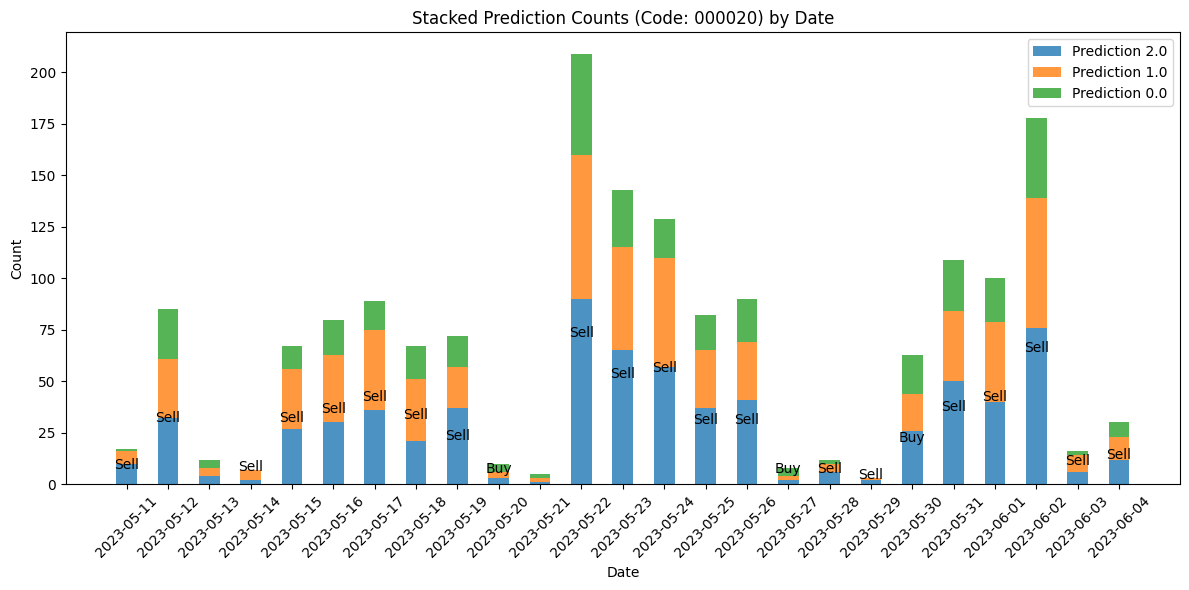

In [78]:
import numpy as np

# Get unique dates and corresponding counts for each prediction category
unique_dates = grouped_df.select("date").distinct().orderBy("date").rdd.flatMap(lambda x: x).collect()

# Get the counts for each prediction category in ascending order
count_0 = grouped_df.orderBy("date").rdd.map(lambda x: x["0.0"]).collect()
count_1 = grouped_df.orderBy("date").rdd.map(lambda x: x["1.0"]).collect()
count_2 = grouped_df.orderBy("date").rdd.map(lambda x: x["2.0"]).collect()

# Create an array of x-coordinates for each date
x = np.arange(len(unique_dates))

# Plot the stacked histogram
plt.figure(figsize=(12, 6))
bar_width = 0.5
opacity = 0.8

plt.bar(x, count_2, bar_width, alpha=opacity, label='Prediction 2.0')
plt.bar(x, count_1, bar_width, bottom=count_2, alpha=opacity, label='Prediction 1.0')
plt.bar(x, count_0, bar_width, bottom=np.add(count_1, count_2), alpha=opacity, label='Prediction 0.0')

# # Add labels to each histogram
for i in range(len(x)):
    total_count = count_0[i] + count_1[i] + count_2[i]
    plt.text(x[i], total_count, f"Buy" if count_0[i] > count_1[i] and count_0[i] > count_2[i] else
                                  f"Sell" if count_1[i] > count_0[i] and count_1[i] > count_2[i] else
                                  f"Neutral", ha='center', va='bottom')
    
# # Add labels to each histogram
# for i in range(len(x)):
#     if count_0[i] > count_1[i]:
#         plt.text(x[i], count_0[i], "Buy", ha='center', va='bottom')
#     elif count_1[i] > count_0[i]:
#         plt.text(x[i], count_1[i], "Sell", ha='center', va='bottom')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Stacked Prediction Counts (Code: 000020) by Date')
plt.xticks(x, unique_dates, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [138]:
spark.stop()

23/06/04 11:21:17 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.
